<a href="https://colab.research.google.com/github/surya-vikram/CV101/blob/main/CNN_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!find /content/drive -name kaggle.json

/content/drive/MyDrive/kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:53<00:00, 23.4MB/s]
100% 1.06G/1.06G [00:53<00:00, 21.5MB/s]


In [6]:
!unzip -q dogs-vs-cats.zip

In [7]:
!pip3 install -q numpy pandas matplotlib seaborn scikit-learn tensorflow keras

In [8]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [9]:
!ls -1 train/cats | wc -l
!ls -1 test/cats | wc -l
!ls -1 train/dogs | wc -l
!ls -1 test/dogs | wc -l

10000
2500
10000
2500


In [10]:
cat_train_dir, cat_test_dir = 'train/cats', 'test/cats'
dog_train_dir, dog_test_dir = 'train/dogs', 'test/dogs'

In [11]:
len(os.listdir(cat_train_dir)), len(os.listdir(cat_test_dir)), len(os.listdir(dog_train_dir)), len(os.listdir(dog_test_dir))

(10000, 2500, 10000, 2500)

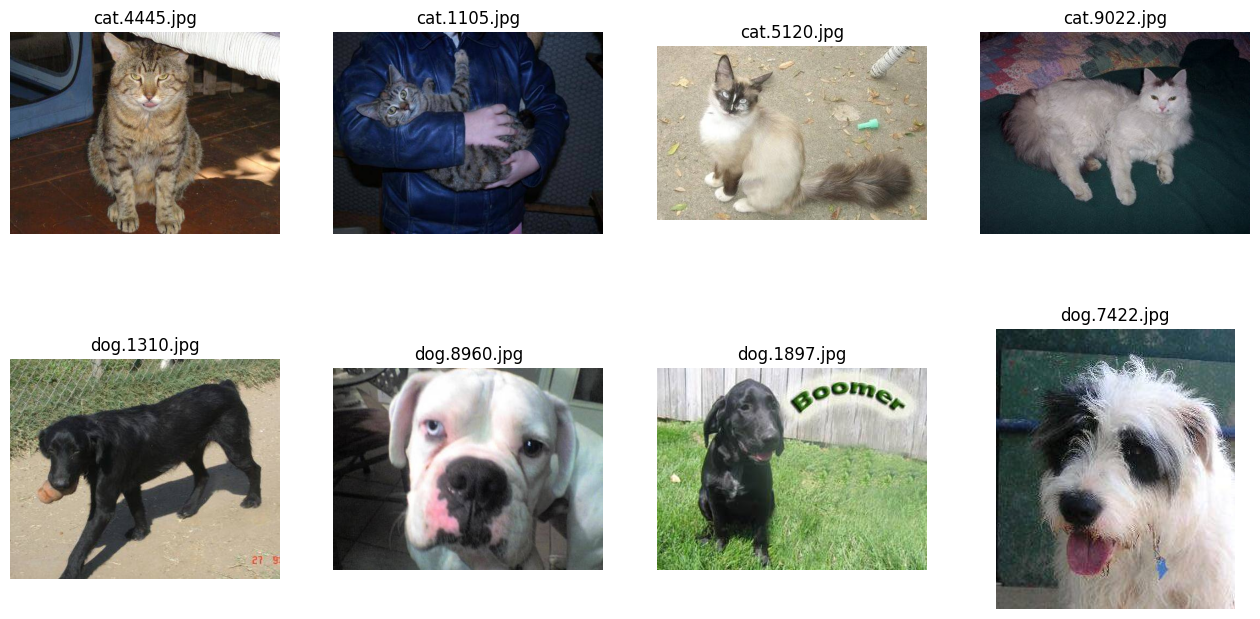

In [12]:
image_dirs = [cat_train_dir, cat_test_dir, dog_train_dir, dog_test_dir]
num_images = 2

plt.figure(figsize=(16, 8))
for i in range(num_images * len(image_dirs)):
  dir_index = i // num_images
  image_dir = image_dirs[dir_index]
  file = random.choice(os.listdir(image_dir))
  image_path = os.path.join(image_dir, file)
  img = load_img(image_path)
  ax = plt.subplot(num_images,len(image_dirs), i + 1)
  plt.imshow(img)
  plt.title(file)
  plt.axis("off")
plt.show()

array([[[255, 242, 244],
        [255, 241, 243],
        [255, 239, 241],
        ...,
        [207, 189, 175],
        [206, 188, 174],
        [205, 187, 173]],

       [[245, 226, 228],
        [245, 226, 228],
        [245, 226, 228],
        ...,
        [204, 186, 172],
        [203, 185, 171],
        [202, 184, 170]],

       [[238, 219, 221],
        [238, 219, 221],
        [239, 220, 222],
        ...,
        [204, 186, 172],
        [203, 185, 171],
        [202, 184, 170]],

       ...,

       [[154, 151, 134],
        [146, 143, 126],
        [143, 140, 123],
        ...,
        [180, 171, 166],
        [181, 172, 165],
        [182, 173, 166]],

       [[162, 159, 142],
        [148, 145, 128],
        [142, 139, 122],
        ...,
        [181, 172, 167],
        [182, 173, 166],
        [182, 173, 166]],

       [[162, 159, 142],
        [150, 147, 130],
        [146, 143, 126],
        ...,
        [185, 176, 171],
        [186, 177, 170],
        [187, 178, 171]]], dtype=uint8)
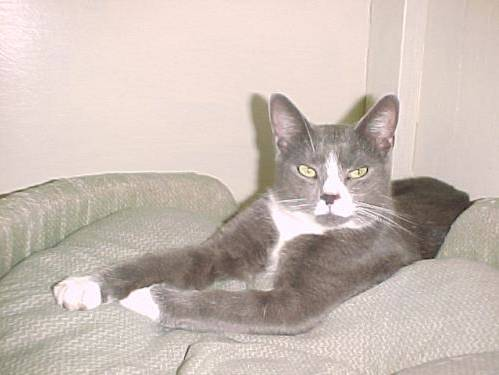

In [13]:
img = cv2.imread(os.path.join(cat_train_dir, os.listdir(cat_train_dir)[1]))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb

In [14]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [15]:
train_gen = data_gen.flow_from_directory(
    'train',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='training'
)

Found 16000 images belonging to 2 classes.


In [16]:
val_gen = data_gen.flow_from_directory(
    'train',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 4000 images belonging to 2 classes.


In [17]:
train_gen.class_indices, val_gen.class_indices

({'cats': 0, 'dogs': 1}, {'cats': 0, 'dogs': 1})

In [18]:
model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
(3*3*3 + 1)*32

896

In [25]:
(3*3*32 + 1)*64

3211776

In [23]:
(3*3*64 + 1)*128

73856

In [24]:
(3*3*128 + 1)*128

147584

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


800/800 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.5653 - loss: 0.6776 - val_accuracy: 0.6097 - val_loss: 0.6931
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 71s 44ms/step - accuracy: 0.7338 - loss: 0.5335 - val_accuracy: 0.7765 - val_loss: 0.4720
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.7875 - loss: 0.4456 - val_accuracy: 0.7692 - val_loss: 0.4998
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.8293 - loss: 0.3764 - val_accuracy: 0.8388 - val_loss: 0.3715
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.8742 - loss: 0.2884 - val_accuracy: 0.8508 - val_loss: 0.3447
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.9133 - loss: 0.2129 - val_accuracy: 0.8495 - val_loss: 0.3544
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9413 - loss: 0.1474 - val_accuracy: 0.8440 - val_loss: 0.4191
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.9636 - loss: 0.0978 - val_accurac

In [32]:
train_score, train_loss, val_score, val_loss = history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss']

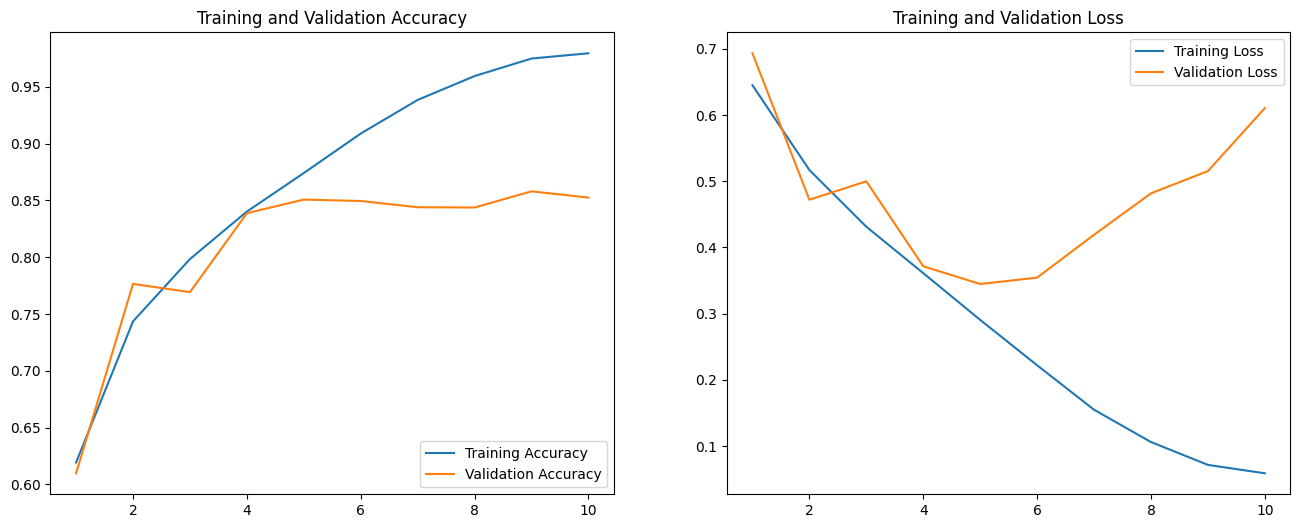

In [35]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_score, label='Training Accuracy')
plt.plot(range(1, 11), val_score, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_loss, label='Training Loss')
plt.plot(range(1, 11), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [38]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

In [39]:
test_gen = data_gen.flow_from_directory(
    'test',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False
)

Found 5000 images belonging to 2 classes.


In [41]:
test_loss, test_score = model.evaluate(test_gen)
print(f"Test Accuracy: {test_score}")
print(f"Test Loss: {test_loss}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8543 - loss: 0.6050
Test Accuracy: 0.8551999926567078
Test Loss: 0.5981339812278748


In [45]:
probabilities = model.predict(test_gen)
probabilities

250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step


array([[4.7616910e-10],
       [1.0091297e-03],
       [4.8443263e-07],
       ...,
       [9.9900085e-01],
       [1.3227919e-01],
       [5.0418667e-02]], dtype=float32)

In [47]:
predictions = (probabilities > 0.5).astype(int).squeeze()
predictions

array([0, 0, 0, ..., 1, 0, 0])

In [48]:
test_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [49]:
test_gen.class_indices

{'cats': 0, 'dogs': 1}

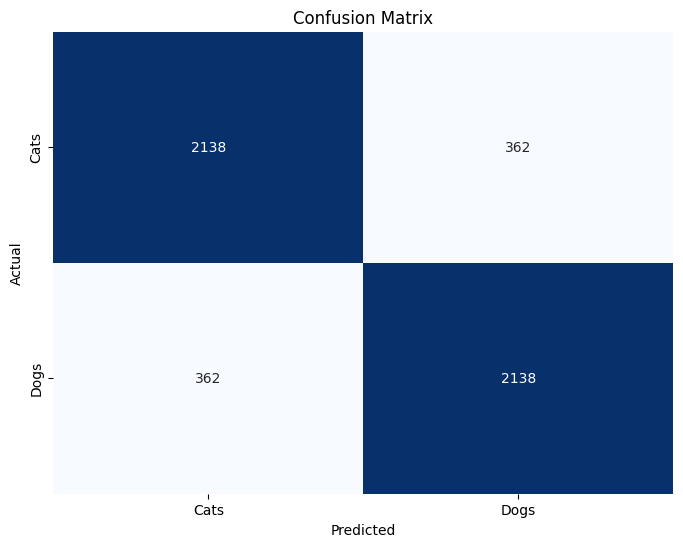

In [50]:
cm = confusion_matrix(test_gen.classes, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Cats', 'Dogs'], yticklabels=['Cats', 'Dogs'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

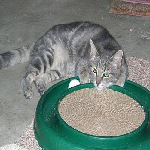

In [51]:
test_img = load_img(os.path.join(cat_test_dir, os.listdir(cat_test_dir)[1]), target_size=(150, 150))
test_img

In [54]:
img_array = img_to_array(test_img)
img_array.shape

(150, 150, 3)

In [55]:
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0
img_array.shape

(1, 150, 150, 3)

In [63]:
print('Cat' if (model.predict(img_array) > 0.5).astype(int).squeeze() == 0 else 'Dog')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Cat
